In [ ]:
import osmnx as ox
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np
from shapely.geometry import Point

# 1. Definir la zona y tus tags exactos
provincia_name = "Provincia de Santiago, Chile"
tags_consistentes = {
    'amenity': 'pastry_shop',
    'shop': ['bakery', 'pastry', 'supermarket']
}

# 2. Descargar la oferta de toda la provincia
print("Buscando oferta en la Provincia de Santiago...")
oferta_prov = ox.features_from_place(provincia_name, tags_consistentes)

# 3. TRATAMIENTO DE DATOS (Para que no se escapen los 7 puntos)
# Separamos puntos y polígonos, y convertimos polígonos a su centro (centroide)
puntos = oferta_prov[oferta_prov.geometry.type == 'Point'].copy()
poligonos = oferta_prov[oferta_prov.geometry.type.isin(['Polygon', 'MultiPolygon'])].copy()
poligonos['geometry'] = poligonos.geometry.centroid

# Unimos todo en una sola capa de puntos reales
oferta_total_prov = pd.concat([puntos, poligonos])

print(f"Total de ofertas encontradas en la Provincia: {len(oferta_total_prov)}")

Buscando oferta en la Provincia de Santiago...
Total de ofertas encontradas en la Provincia: 1124


/tmp/ipython-input-182211805.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  poligonos['geometry'] = poligonos.geometry.centroid


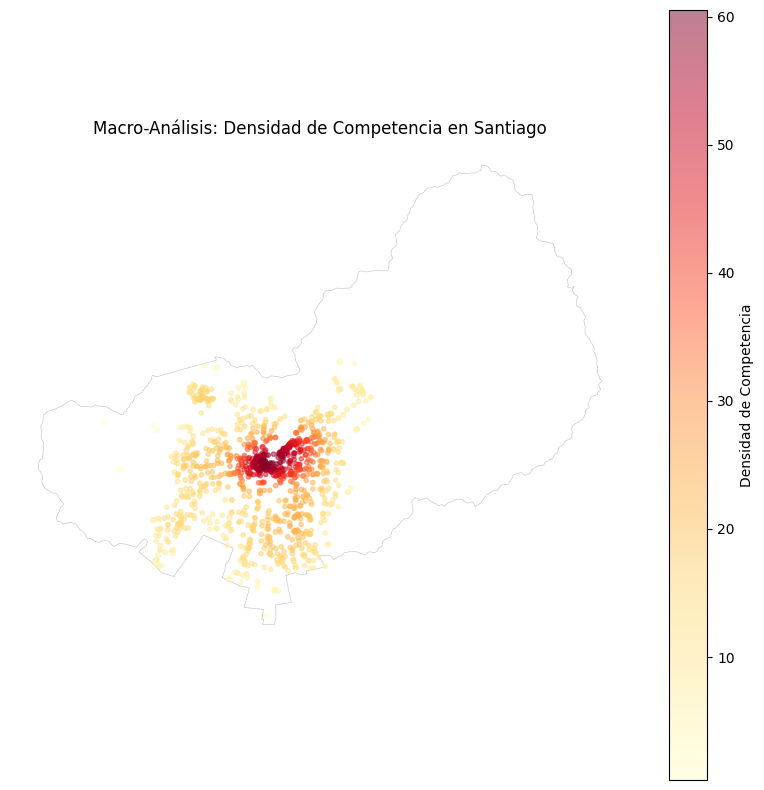

In [ ]:
# Extraer coordenadas para el Heatmap
x = oferta_total_prov.geometry.x
y = oferta_total_prov.geometry.y

# Calcular densidad
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# Graficar
fig, ax = plt.subplots(figsize=(10, 10))
# Dibujar el límite de la provincia para fondo
prov_boundary = ox.geocode_to_gdf(provincia_name)
prov_boundary.plot(ax=ax, facecolor='none', edgecolor='#cccccc', linewidth=0.5)

# Heatmap
scatter = ax.scatter(x, y, c=z, s=10, cmap='YlOrRd', alpha=0.5)
plt.colorbar(scatter, label='Densidad de Competencia')
ax.set_title("Macro-Análisis: Densidad de Competencia en Santiago")
plt.axis('off')
plt.show()

Descargando límites comunales...

--- RANKING DE OFERTA POR COMUNA ---
comuna_corta
Santiago       137
Providencia     90
Las Condes      85
Maipú           81
Ñuñoa           67
La Florida      63
Macul           37
Peñalolén       36
Name: count, dtype: int64


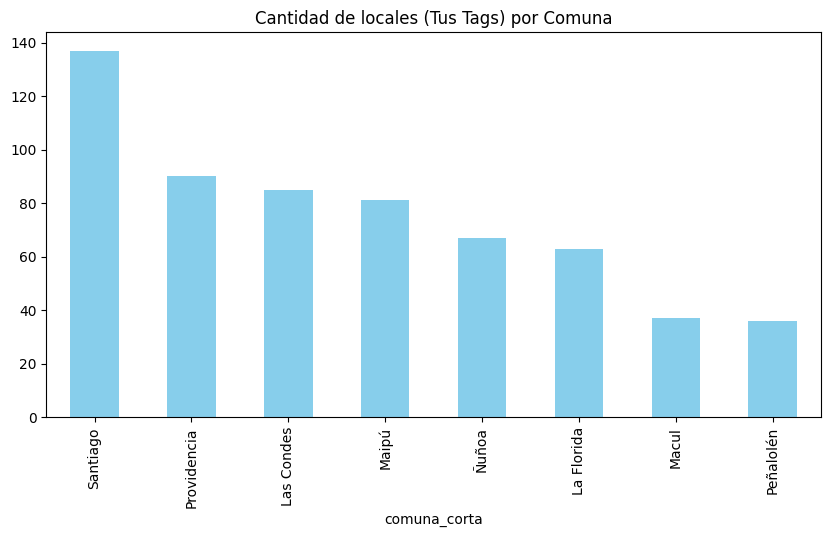

In [ ]:
# 1. Definimos las comunas que queremos comparar (puedes agregar más)
nombres_comunas = [
    "La Florida, Chile", "Santiago, Chile", "Las Condes, Chile",
    "Providencia, Chile", "Ñuñoa, Chile", "Maipú, Chile",
    "Puente Alto, Chile", "Macul, Chile", "Peñalolén, Chile"
]

print("Descargando límites comunales...")
# Descargamos los polígonos de las comunas
comunas_gdf = ox.geocode_to_gdf(nombres_comunas)

# 2. Aseguramos que los puntos de oferta y las comunas tengan el mismo CRS (coordenadas)
oferta_total_prov = oferta_total_prov.to_crs(comunas_gdf.crs)

# 3. CRUCE ESPACIAL (Punto en Polígono)
# 'display_name' suele ser el campo que contiene el nombre de la comuna en geocode_to_gdf
union_comunas = gpd.sjoin(oferta_total_prov, comunas_gdf[['display_name', 'geometry']], how="inner", predicate="within")

# 4. Limpieza del nombre (para que solo salga "La Florida" y no toda la dirección)
union_comunas['comuna_corta'] = union_comunas['display_name'].apply(lambda x: x.split(',')[0])

# 5. RESULTADO FINAL
ranking = union_comunas['comuna_corta'].value_counts()
print("\n--- RANKING DE OFERTA POR COMUNA ---")
print(ranking)

# Visualización rápida para verificar
union_comunas['comuna_corta'].value_counts().plot(kind='bar', figsize=(10,5), color='skyblue')
plt.title("Cantidad de locales (Tus Tags) por Comuna")
plt.show()

Descargando límites y oferta...


/tmp/ipython-input-1057633413.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polis['geometry'] = polis.geometry.centroid


✅ Se han identificado 63 puntos de oferta final.


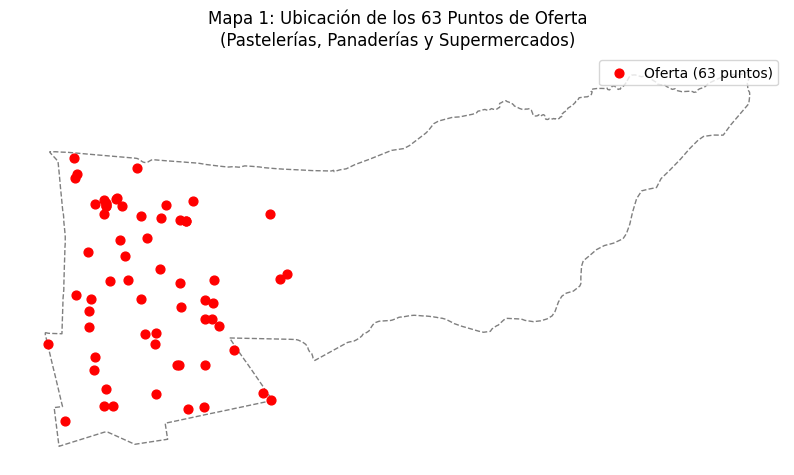

In [ ]:
import osmnx as ox
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# 1. Configuración de Tags (Tus tags exactos)
tags = {'amenity': 'pastry_shop', 'shop': ['bakery', 'pastry', 'supermarket']}

# 2. Descargar límites de La Florida y la Provincia para el cruce
print("Descargando límites y oferta...")
la_florida_gdf = ox.geocode_to_gdf("La Florida, Santiago, Chile")
oferta_prov = ox.features_from_place("Provincia de Santiago, Chile", tags)

# 3. Procesamiento técnico: Convertir Polígonos a Puntos (Centroides)
puntos = oferta_prov[oferta_prov.geometry.type == 'Point'].copy()
polis = oferta_prov[oferta_prov.geometry.type.isin(['Polygon', 'MultiPolygon'])].copy()
polis['geometry'] = polis.geometry.centroid
oferta_total_pts = pd.concat([puntos, polis]).to_crs(la_florida_gdf.crs)

# 4. Cruce Espacial (SJOIN) para obtener los 63 puntos exactos de La Florida
oferta_florida = gpd.sjoin(oferta_total_pts, la_florida_gdf, how="inner", predicate="within")

print(f"✅ Se han identificado {len(oferta_florida)} puntos de oferta final.")

# --- MAPA 1: LOCALIZACIÓN DE PUNTOS ---
fig, ax = plt.subplots(figsize=(10, 10))
la_florida_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linestyle='--', alpha=0.5)
oferta_florida.plot(ax=ax, color='red', markersize=40, label=f'Oferta ({len(oferta_florida)} puntos)')
ax.set_title("Mapa 1: Ubicación de los 63 Puntos de Oferta\n(Pastelerías, Panaderías y Supermercados)")
ax.axis('off')
plt.legend()
plt.show()

/tmp/ipython-input-351539562.py:23: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  isocronas_list.append(gpd.GeoDataFrame(geometry=node_points).geometry.unary_union.convex_hull)
/tmp/ipython-input-351539562.py:23: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  isocronas_list.append(gpd.GeoDataFrame(geometry=node_points).geometry.unary_union.convex_hull)
/tmp/ipython-input-351539562.py:23: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  isocronas_list.append(gpd.GeoDataFrame(geometry=node_points).geometry.unary_union.convex_hull)
/tmp/ipython-input-351539562.py:23: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  isocronas_list.append(gpd.GeoDataFrame(geometry=node_points).geometry.unary_union.convex_hull)
/tmp/ipython-input-351539562.py:23: DeprecationWarning: The 'una

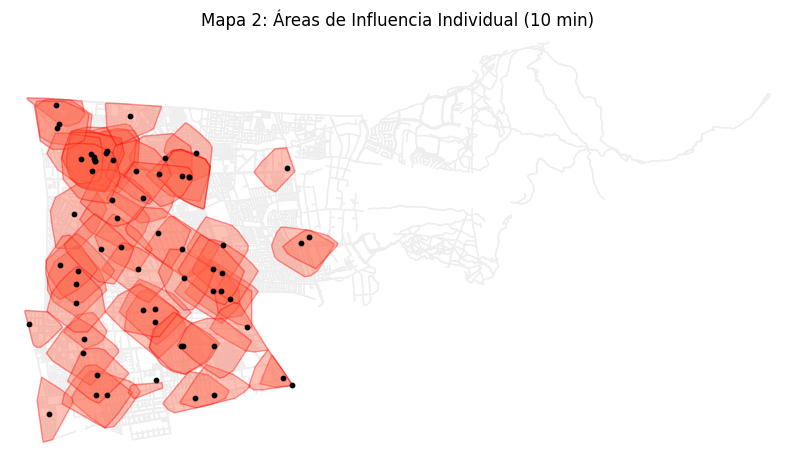

In [ ]:
import networkx as nx
from shapely.geometry import Point

# 1. Descargar red de caminata de La Florida
G = ox.graph_from_place("La Florida, Santiago, Chile", network_type='walk')
G_proj = ox.project_graph(G) # Proyectar para medir en metros

# 2. Configuración de tiempo (10 min a 4.5 km/h)
trip_time = 10
meters_per_minute = (4.5 * 1000) / 60
for u, v, k, data in G_proj.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

# 3. Encontrar nodos y generar polígonos
oferta_proj = oferta_florida.to_crs(G_proj.graph['crs'])
oferta_proj['node'] = ox.nearest_nodes(G_proj, oferta_proj.geometry.x, oferta_proj.geometry.y)

isocronas_list = []
for node in oferta_proj['node']:
    subgraph = nx.ego_graph(G_proj, node, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for n, data in subgraph.nodes(data=True)]
    if len(node_points) >= 3:
        isocronas_list.append(gpd.GeoDataFrame(geometry=node_points).geometry.unary_union.convex_hull)

isocronas_gdf = gpd.GeoDataFrame(geometry=isocronas_list, crs=G_proj.graph['crs'])

# --- MAPA 2: DETALLE DE ISÓCRONAS ---
fig, ax = plt.subplots(figsize=(10, 10))
ox.plot_graph(G_proj, ax=ax, show=False, close=False, edge_color='#eeeeee', node_size=0)
isocronas_gdf.plot(ax=ax, color='tomato', alpha=0.4, edgecolor='red', label='Isócronas 10 min')
oferta_proj.plot(ax=ax, color='black', markersize=10)
ax.set_title("Mapa 2: Áreas de Influencia Individual (10 min)")
plt.show()

/tmp/ipython-input-481436030.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  manto_geometry = isocronas_gdf.geometry.unary_union
/tmp/ipython-input-481436030.py:16: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


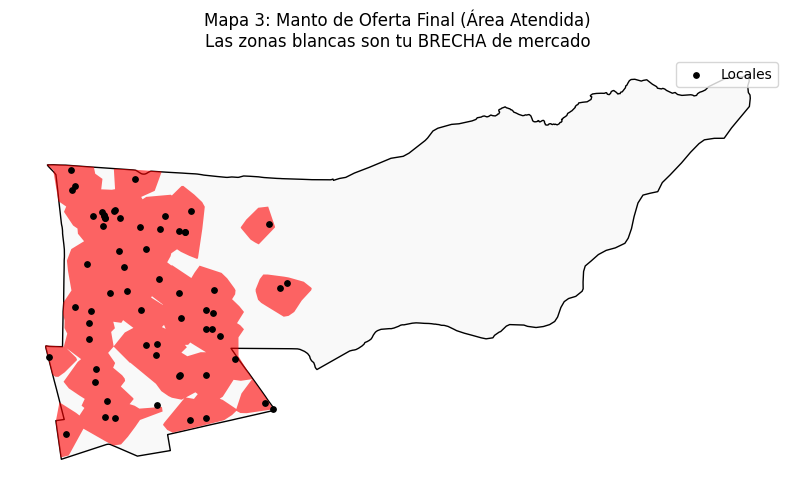

✅ Archivo 'manto_oferta_63.geojson' listo para descargar.


In [ ]:
# 1. Unir todas las isocronas en una sola geometría (Manto)
manto_geometry = isocronas_gdf.geometry.unary_union
manto_oferta = gpd.GeoDataFrame(geometry=[manto_geometry], crs=G_proj.graph['crs'])

# --- MAPA 3: MANTO DE OFERTA FINAL ---
fig, ax = plt.subplots(figsize=(10, 10))
# Dibujamos el límite de la comuna
la_florida_gdf.to_crs(G_proj.graph['crs']).plot(ax=ax, facecolor='#f9f9f9', edgecolor='black', linewidth=1)
# Dibujamos el manto (La zona "ocupada")
manto_oferta.plot(ax=ax, color='red', alpha=0.6, label='Área Cubierta por Competencia')
# Dibujamos los puntos
oferta_proj.plot(ax=ax, color='black', markersize=15, label='Locales')

ax.set_title("Mapa 3: Manto de Oferta Final (Área Atendida)\nLas zonas blancas son tu BRECHA de mercado")
ax.axis('off')
plt.legend()
plt.show()

# 2. Exportar para trabajar en R
manto_oferta.to_crs("EPSG:4326").to_file("manto_oferta_63.geojson", driver='GeoJSON')
print("✅ Archivo 'manto_oferta_63.geojson' listo para descargar.")